## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


In [35]:
## 00 - Config notebook
save_nodes_proximity = True
nodes_proximity_dir = "../../data/external/temporal_fromjupyter/arroyo_vivo/prox_mercados_nodes.gpkg"

## 00 - Required data

In [2]:
# Location of area of interest (Required)
aoi_dir = "../../data/external/temporal_todocker/arroyo_vivo/poligono_proyectoarroyovivo_32614.gpkg"

# Name of points of interest (Required)
pois_name = 'mercados'
# Location of points of interest (Required)
pois_dir = "../../data/external/temporal_todocker/arroyo_vivo/mercados_pulgas_tianguis_cuenca_32614.gpkg"

## 01 - Find nodes proximity to pois in aoi

In [14]:
def find_nodes_proximity(aoi_dir,pois_dir,pois_name):

    #-------------------------------------------------- Create OSMnx network

    # Read area of interest (aoi)
    aoi = gpd.read_file(aoi_dir)
    aoi = aoi.to_crs("EPSG:4326")

    # Create OSMnx network for area of interest
    G, nodes, edges = aup.create_osmnx_network(aoi,how='from_polygon',network_type='all_private')

    #-------------------------------------------------- Assign nearest node(osmid) to each point of interest

    # Load pois
    pois = gpd.read_file(pois_dir)
    pois = pois.to_crs("EPSG:4326")

    # Filter pois
    pois_aoi = gpd.sjoin(pois,aoi,how='inner')

    # Format to calculate nearest
    nodes_gdf = nodes.set_crs("EPSG:4326")
    edges_gdf = edges.set_crs("EPSG:4326")
    nodes_gdf = nodes_gdf.set_index('osmid')
    edges_gdf = edges_gdf.set_index(["u", "v", "key"])

    # Calculate nearest
    nearest = aup.find_nearest(G, nodes_gdf, pois, return_distance= True)
    print("Calculated distances from pois to nearest node.")

    #-------------------------------------------------- Calculate distance from each node to nearest poi
    # Format
    edges_gdf['length'].fillna(edges_gdf['length'].mean(),inplace=True)

    # ELEMENTS NEEDED OUTSIDE THE LOOP
    # df_temp: Each column will store a batch of procesed nodes.
    df_temp = nodes_gdf.copy()

    # ELEMENTS NEEDED OUTSIDE THE LOOP
    # nodes_analysis is a nodes_gdf (index reseted) used in aup.calculate_distance_nearest_poi
    nodes_analysis = nodes_gdf.reset_index().copy()

    # ELEMENTS NEEDED OUTSIDE THE LOOP
    #nodes_distance: Minimum time/distance found in all batches will be added from df_min (within if/elif/else) to nodes_distance 
    # (which keeps x,y and geometry data)
    nodes_distance = nodes_gdf.copy()

    s = pois_name

    if len(nearest) % 250:
        batch_size = len(nearest)/200
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k+1} of {int(batch_size)+1} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = nearest.iloc[int(200*k):int(200*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')

            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]

            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)

        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)

        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)

        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)

        #Final data gets converted to time, assuming a walking speed of 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000

    else:
        batch_size = len(nearest)/250
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k+1} of {int(batch_size)+1} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = nearest.iloc[int(250*k):int(250*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_gdf, s, 'osmid', wght='length')

            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]

            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)

        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)

        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)

        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)

        #Final data gets converted to time, assuming a walking speed of 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000

    #Format nodes_time
    nodes_time['source'] = s
    nodes_time.reset_index(inplace=True)
    nodes_time = nodes_time.set_crs("EPSG:4326")
    nodes_time = nodes_time[['osmid','time','source','x','y','geometry']]

    return nodes_time

In [15]:
nodes_time = find_nodes_proximity(aoi_dir,pois_dir,pois_name)
nodes_time

Created OSMnx graph from bounding polygon.
Converted OSMnx graph to 4855 nodes and 11743 edges GeoDataFrame.
Added column width for edges.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: lanes in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Calculated distances from pois to nearest node.
Starting range k = 1 of 1 for source mercados.


,osmid,time,source,x,y,geometry
0,292505890,44.799600,mercados,-100.296978,25.659477,POINT (-100.29698 25.65948)
1,293679561,42.429405,mercados,-100.332355,25.650647,POINT (-100.33235 25.65065)
2,293679705,30.833265,mercados,-100.325947,25.646781,POINT (-100.32595 25.64678)
3,293680916,9.610260,mercados,-100.305196,25.634046,POINT (-100.30520 25.63405)
4,293680934,13.032510,mercados,-100.315972,25.640701,POINT (-100.31597 25.64070)
...,...,...,...,...,...,...
4850,11123441633,49.087935,mercados,-100.333943,25.638541,POINT (-100.33394 25.63854)
4851,11184755006,35.431605,mercados,-100.328983,25.641449,POINT (-100.32898 25.64145)
4852,11184776392,31.094325,mercados,-100.322373,25.639129,POINT (-100.32237 25.63913)
4853,11184790017,36.524265,mercados,-100.329517,25.642189,POINT (-100.32952 25.64219)


## 02 - Visualize

<Axes: >

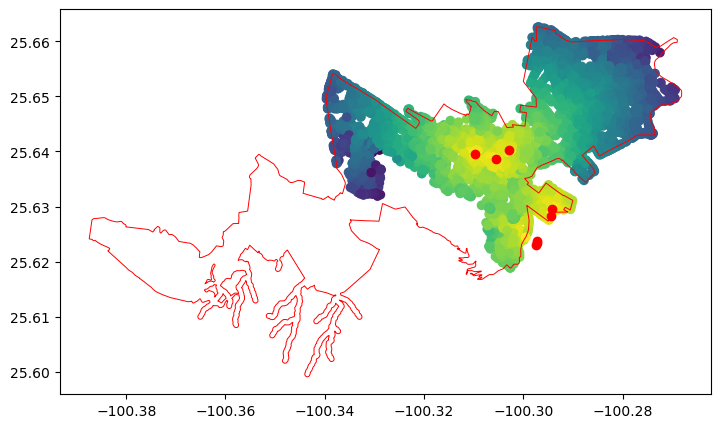

In [27]:
# Read area of interest (aoi)
aoi = gpd.read_file(aoi_dir)
aoi = aoi.to_crs("EPSG:4326")

# Load pois
pois = gpd.read_file(pois_dir)
pois = pois.to_crs("EPSG:4326")

fig,ax = plt.subplots(figsize=(10,5))
pois.plot(c='red',ax=ax,zorder=2)
nodes_time.plot('time',cmap='viridis_r',ax=ax,zorder=1)
aoi.plot(ax=ax,zorder=2,facecolor="none", edgecolor='red', lw=0.7)

## 03 - Save

In [37]:
if save_nodes_proximity:
    nodes_time.to_file(nodes_proximity_dir, driver='GPKG')